selfie.shape: (256, 256, 3)
anime.shape: (256, 256, 3)
selfie.shape: (256, 256, 3)
anime.shape: (256, 256, 3)
selfie.shape: (256, 256, 3)
anime.shape: (256, 256, 3)
selfie.shape: (256, 256, 3)
anime.shape: (256, 256, 3)
selfie.shape: (256, 256, 3)
anime.shape: (256, 256, 3)
selfie.shape: (256, 256, 3)
anime.shape: (256, 256, 3)


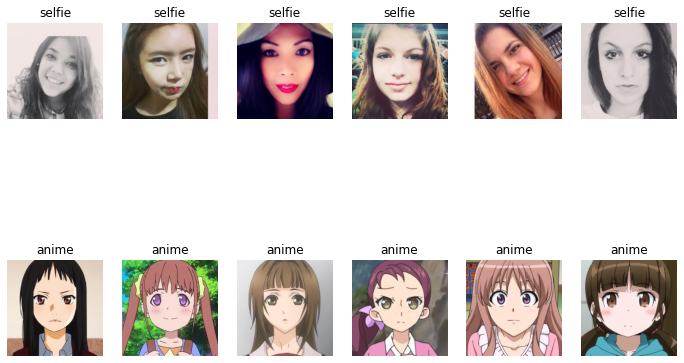

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os

idxs = [1, 2, 5, 6, 7, 8]
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(12, 8))

# selfie_dir = "data/trainA/"
# anime_dir = "data/trainB/"

selfie_dir = "data/testA/"
anime_dir = "data/testB/"

selfie_files = os.listdir(selfie_dir)
anime_files = os.listdir(anime_dir)


for i, idx in enumerate(idxs):

    selfie = plt.imread(selfie_dir+selfie_files[idx])
    anime = plt.imread(anime_dir+anime_files[idx])

    print('selfie.shape:', selfie.shape)
    print('anime.shape:', anime.shape)

    axes[0][i].axis('off')
    axes[0][i].imshow(selfie)
    axes[0][i].set_title("selfie")

    axes[1][i].imshow(anime)
    axes[1][i].axis('off')
    axes[1][i].set_title("anime")